# Figure 3: model-based coupling

In [2]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py

import numpy as np

# import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from himalaya.scoring import correlation_score
from scipy.stats import pearsonr

from util import plot, subject, stats
from util.path import Path
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [3]:
%cd ..

/scratch/gpfs/zzada/fconv


In [4]:
modelname = "joint"
features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

cache = 'default_task'

encmodel = f"encoding_{cache}"

FG_MASK = get_brainmask()

modelname, encmodel, cache

('joint', 'encoding_default_task', 'default_task')

In [5]:
cachedir = f"results/cache/figure3-mbc/{modelname}/{cache}/"
resultdir = f'figures/figure3/{encmodel}/{modelname}/{cache}'
!mkdir -p $resultdir
!mkdir -p $cachedir
cachedir

'results/cache/figure3-mbc/joint/default_task/'

In [6]:
enc_sigmask = np.load(f'results/cache/figure2-{encmodel}/joint/{cache}/sigmask.npy')

In [39]:
def get_mbc(modelname:str):
    mbc_scores = defaultdict(list)

    # use subA's predictions on subB's actual neural data
    for subA in tqdm(SUBS_STRANGERS):
        # load subA preds
        encpath = Path(root='results/' + encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
        with h5py.File(encpath, "r") as f:
            prod_predA = f["cv_preds"][:, -2]  # (5, 6, 240, 81924)
            comp_predA = f["cv_preds"][:, -1]
            prodmaskA = f["cv_prodmask"][...]

        # load subB preds
        subB = subject.get_partner(subA)
        encpath = Path(root='results/' + encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
        with h5py.File(encpath, "r") as f:
            nuis_predsB = f["cv_preds"][:, :-2].sum(1)

        dataB = subject.get_bold(subB, cache=cache)
        resB = dataB.reshape(5, 240, -1) - nuis_predsB

        compmaskA = ~prodmaskA

        for i in range(5):
            mbc_scores["prod"].append(correlation_score(prod_predA[i][prodmaskA[i]], resB[i][prodmaskA[i]]))
            mbc_scores["comp"].append(correlation_score(comp_predA[i][compmaskA[i]], resB[i][compmaskA[i]]))

    sub_mbc_prod = np.stack(mbc_scores["prod"])
    sub_mbc_comp = np.stack(mbc_scores["comp"])
    
    return sub_mbc_prod, sub_mbc_comp

In [40]:
sub_mbc_prod, sub_mbc_comp = get_mbc(modelname)
sub_mbc_prod.shape

100%|██████████| 58/58 [04:03<00:00,  4.20s/it]


(290, 81924)

In [41]:
# save
with h5py.File(f"{cachedir}/mbc.hdf5", "w") as f:
    f.create_dataset(name="prod", data=sub_mbc_prod)
    f.create_dataset(name="comp", data=sub_mbc_comp)

In [7]:
# read
with h5py.File(f"{cachedir}/mbc.hdf5", "r") as f:
    sub_mbc_prod = f["prod"][...]
    sub_mbc_comp = f["comp"][...]

In [8]:
sub_mbc = (sub_mbc_prod + sub_mbc_comp) / 2
avg_mbc = (sub_mbc_prod.mean(0) + sub_mbc_comp.mean(0)) / 2
sub_mbc.shape, avg_mbc.shape

((290, 81924), (81924,))

In [9]:
sigmask = stats.ttest_1samp(sub_mbc, method='fdr_bh', alpha=0.05)
sigmask.sum()

25645

In [12]:
avg_mbc.max()

0.084725425

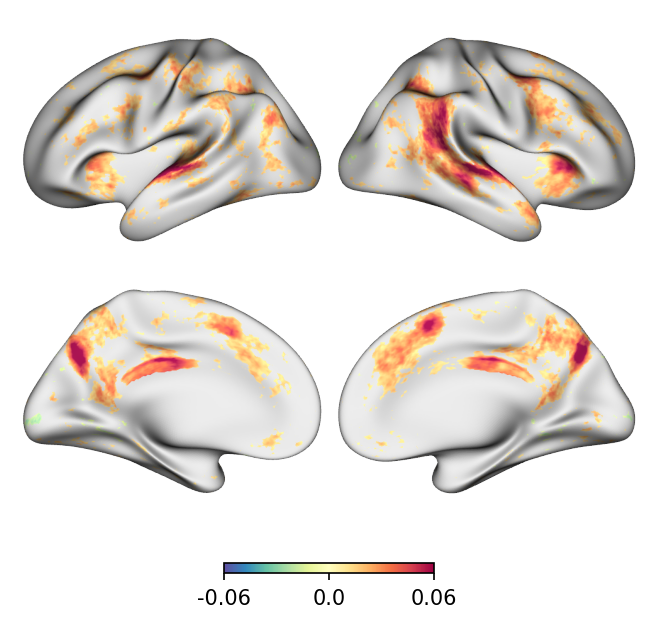

In [14]:
fig = plot.surface_plot(avg_mbc, threshold=~sigmask, cmap="Spectral_r")
# fig = plot.surface_plot(avg_mbc, threshold=~enc_sigmask, cmap="Spectral_r")
fig.savefig(f'{resultdir}/mbc.svg')

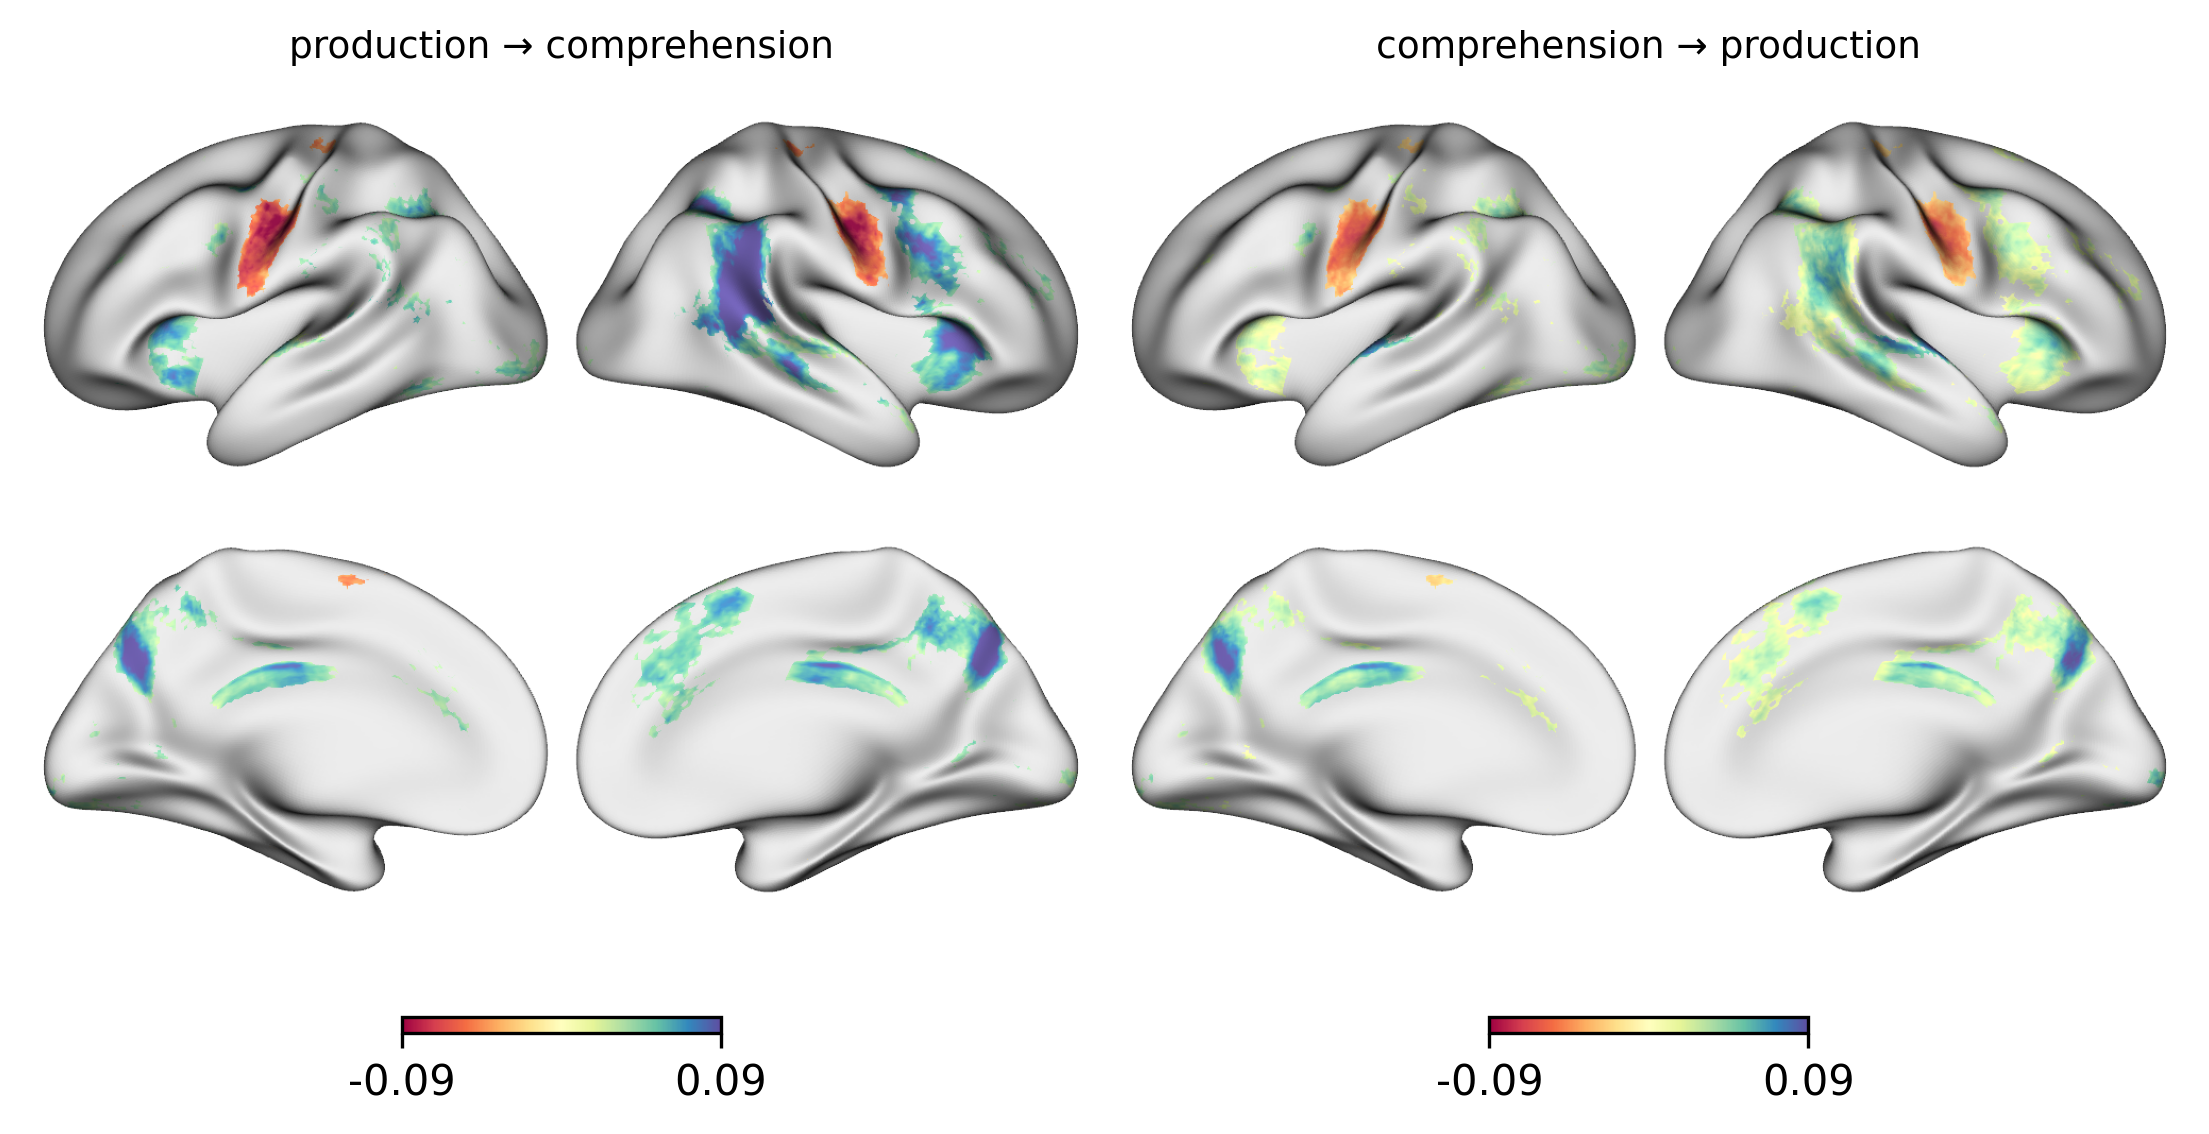

In [13]:
values1 = sub_mbc_prod.mean(0)
values2 = sub_mbc_comp.mean(0)
prod_cmap = comp_cmap = 'Spectral'

fig, axes = plt.subplots(1, 2, figsize=(7.25, 4), layout='constrained', dpi=300)
plot.surface_plot(values1, threshold=~sigmask, fig=fig, ax=axes[0], vmax=0.09, cmap=prod_cmap, title='production → comprehension')
plot.surface_plot(values2, threshold=~sigmask, fig=fig, ax=axes[1], vmax=0.09, cmap=comp_cmap, title='comprehension → production')
fig.show()

# enc scatter (skip)

In [15]:
respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

results = []
results_prod = []
results_comp = []
for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue
    with h5py.File(respath, "r") as f:
        prod = f['cv_scores_prod'][:, -2] 
        comp = f['cv_scores_comp'][:, -1]
        results.append(np.mean(prod + comp, axis=0))
        results_prod.append(prod.mean(0))
        results_comp.append(comp.mean(0))

sub_enc_perf = np.stack(results)
avg_enc_perf = sub_enc_perf.mean(0)
avg_enc_perf.shape

100%|██████████| 58/58 [00:01<00:00, 45.77it/s]


(81924,)

In [16]:
prod_scores = np.stack(results_prod).mean(0)
comp_scores = np.stack(results_comp).mean(0)

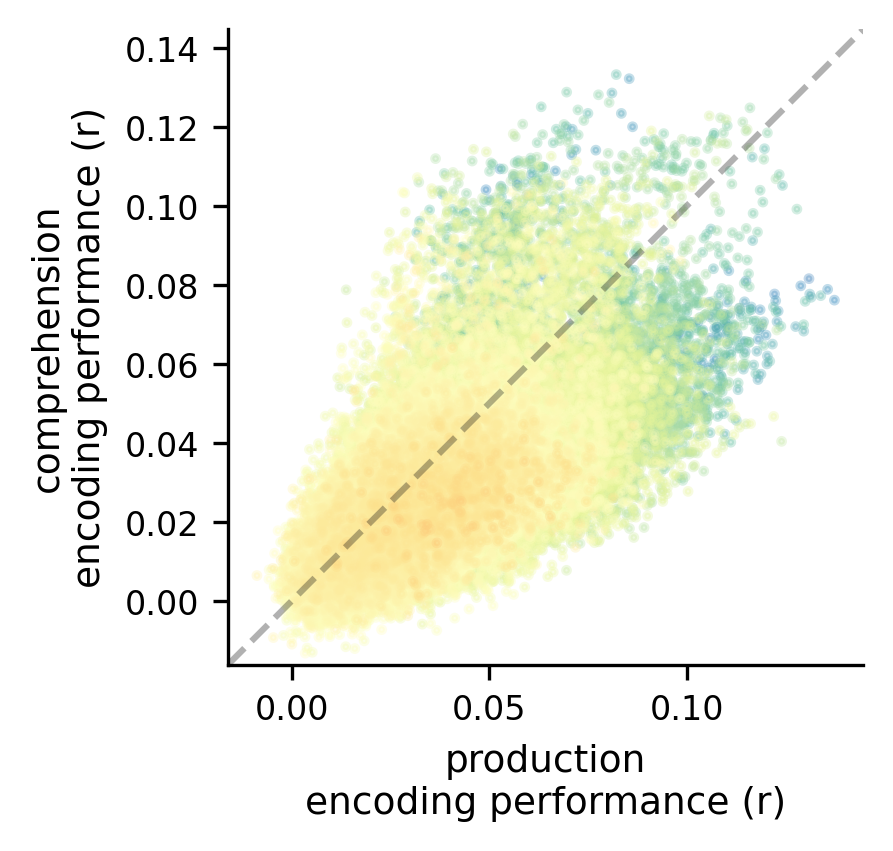

In [17]:
values1 = prod_scores
values2 = comp_scores

vox_colors = avg_mbc

order = vox_colors.argsort()[::-1]

fig = plt.figure(figsize=(2.75, 2.75), dpi=300)
ax = fig.add_subplot()

# ax.axvline(0, c="k", zorder=1, alpha=1)
# ax.axhline(0, c="k", zorder=1, alpha=1)
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, c="k", ls='dashed')

im = ax.scatter(
    values1[order], values2[order], c=vox_colors[order], s=10, alpha=0.3,
    # edgecolors='black', linewidths=0.25, marker='o',
    marker='.',
    cmap='Spectral', vmin=-.1, vmax=0.1)
ax.set_aspect("equal", "box")

lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], lim)
ax.set_ylim(ax.get_xlim()[0], lim)

ax.set_xlabel("production\nencoding performance (r)")
ax.set_ylabel("comprehension\nencoding performance (r)")

# cbar = fig.colorbar(im, shrink=0.86)
# cbar.set_label("density")

# cbar = fig.colorbar(im, ax=ax)

fig.show()

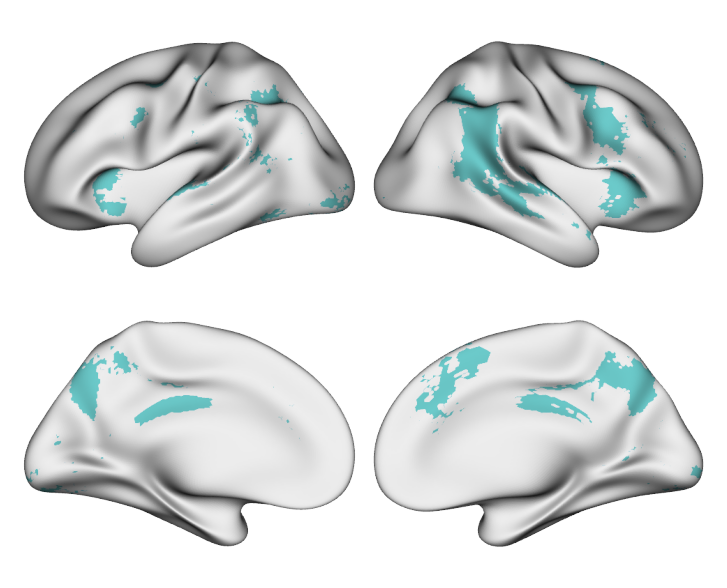

In [21]:
# positive
mask = enc_sigmask & sigmask & (avg_mbc > 0.03)
values2 = np.ones_like(avg_mbc)
values2[~mask] = 0
plot.surface_plot(values2, cbar=False, vmin=0, cmap='Spectral', vmax=1.2);

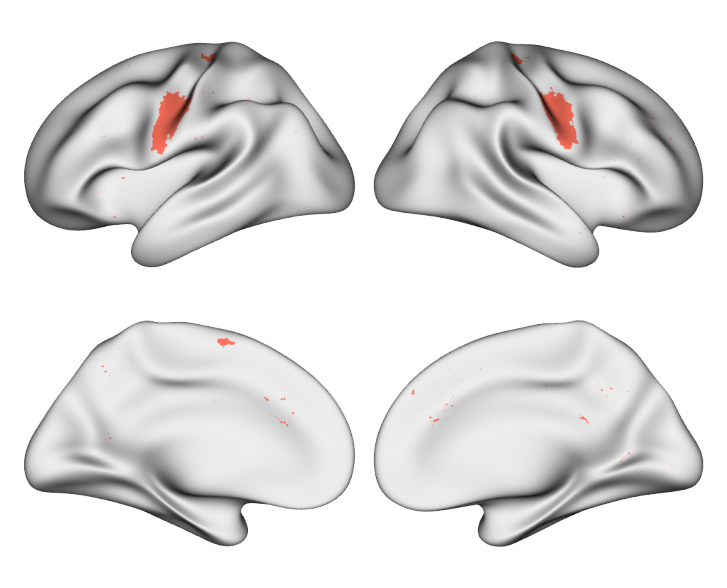

In [24]:
mask = enc_sigmask & (avg_mbc < .03) & sigmask
values2 = np.ones_like(avg_mbc)
values2[~mask] = 0
plot.surface_plot(values2, cbar=False, vmin=0, cmap='Spectral_r', vmax=1.2);

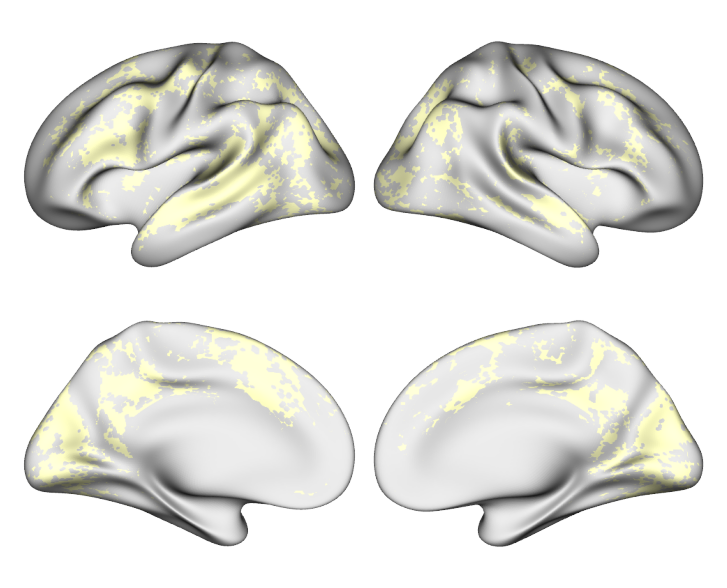

In [26]:
mask = enc_sigmask & (avg_mbc < .03) & (avg_mbc > -.03)
values2 = np.ones_like(avg_mbc)
values2[~mask] = 0
plot.surface_plot(values2, cbar=False, vmin=0, vmax=2, cmap='Spectral_r');

# corr with encoding

In [18]:
r, p = pearsonr(avg_enc_perf[FG_MASK], avg_mbc[FG_MASK])
print(r, p)
print('abs', pearsonr(avg_enc_perf, np.abs(avg_mbc)))

0.5913372997411902 0.0
abs PearsonRResult(statistic=0.6573371057237348, pvalue=0.0)


In [19]:
with h5py.File(f"results/cache/figurex-isc/{cache}/full_isc_avg.hdf5", "r") as f:
    avg_isc = f["avg_isc"][...]
    # sigmask_isc = f["sigmask"][...]

In [34]:
import matplotlib as mpl

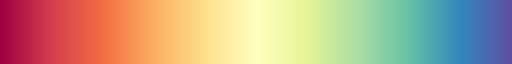

In [35]:
cm = plt.get_cmap("Spectral")
norm = mpl.colors.Normalize(vmin=-.1, vmax=.1)
cm.set_bad(color='Gray', alpha=1)
cm

In [20]:
pearsonr(avg_mbc, avg_isc)

PearsonRResult(statistic=0.7440386952961529, pvalue=0.0)

In [ ]:
values1 = avg_enc_perf
values2 = avg_mbc

vox_colors = avg_isc

order = vox_colors.argsort()[::-1]

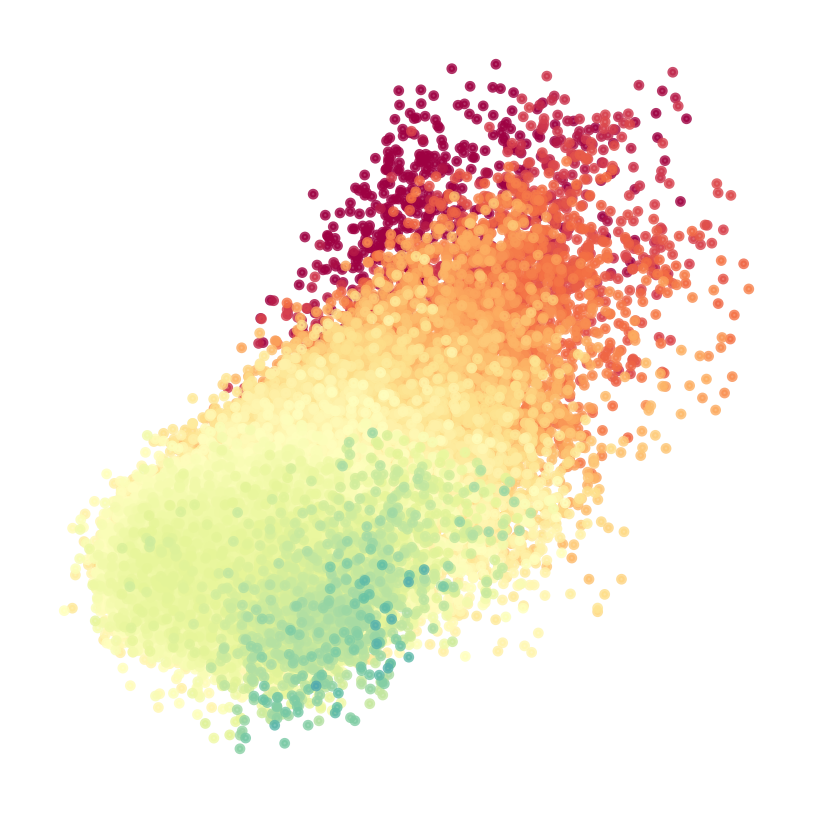

In [41]:
fig = plt.figure(figsize=(2.75, 2.75), layout='tight', dpi=300)
ax = fig.add_subplot()

im = ax.scatter(
    values1[order], values2[order], c=vox_colors[order],
    s=10, alpha=0.8, marker='.',
    cmap='Spectral_r', vmin=-.07, vmax=0.07)

ax.set_ylabel("MBC (r)")
ax.set_xlabel("LLM encoding performance\n(prod + comp r)")

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.set_axis_off()
fig.savefig(f'{resultdir}/enc-mbc.png', dpi=300, bbox_inches=0)
fig.show()

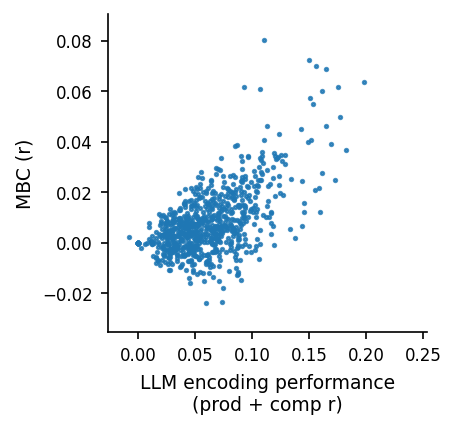

In [38]:
fig = plt.figure(figsize=(2.75, 2.75))
ax = fig.add_subplot()

im = ax.scatter(values1[order[::100]], values2[order[::100]], s=10, alpha=0.8, marker='.',)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_ylabel("MBC (r)")
ax.set_xlabel("LLM encoding performance\n(prod + comp r)")

fig.savefig(f'{resultdir}/enc-mbc.svg')
fig.show()

In [16]:
plot_params = dict(cmap="Grays", vmin=0, vmax=1, cbar=False, size=(800, 200), zoom=1.2, layout='row', mirror_views=True)

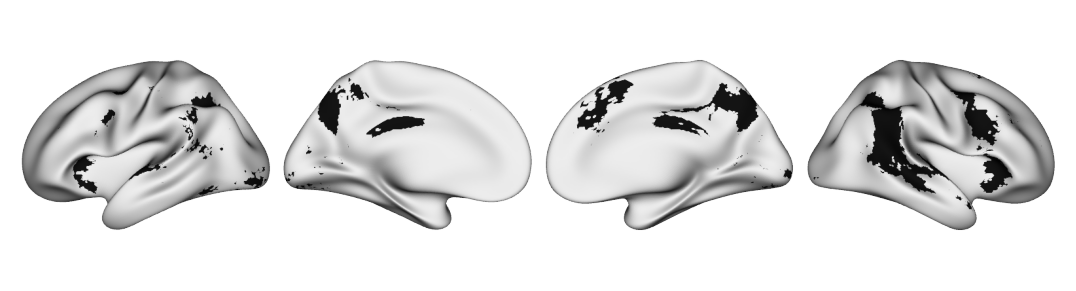

In [17]:
# positive
mask = (avg_enc_perf > .1) & (avg_mbc > .03)
values2 = np.ones_like(avg_mbc)
values2[~mask] = 0
plot.surface_plot(values2, **plot_params);

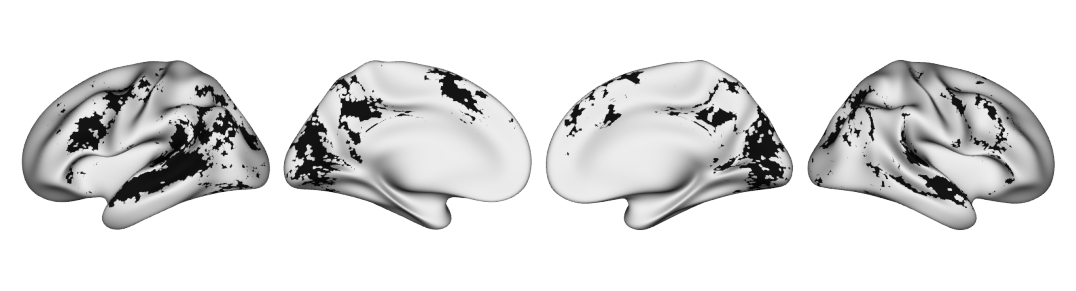

In [18]:
# within only
mask = (avg_enc_perf > .1) & (np.abs(avg_mbc) < .03)
values2 = np.ones_like(avg_mbc)
values2[~mask] = 0
plot.surface_plot(values2, **plot_params);

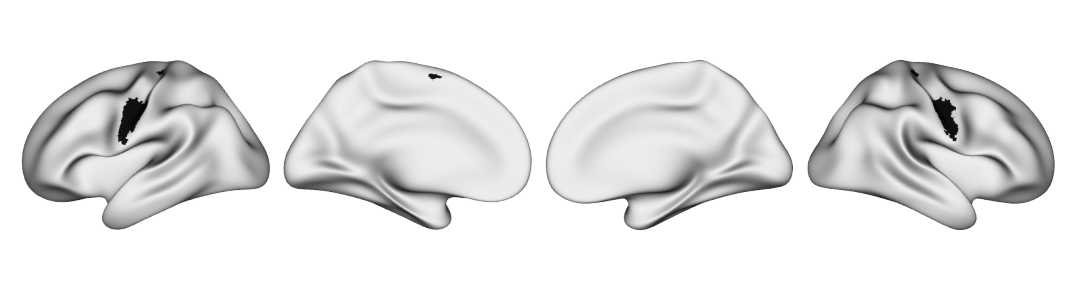

In [19]:
# negative
mask = (avg_enc_perf > .1) & (avg_mbc < -.03)
values2 = np.ones_like(avg_mbc)
values2[~mask] = 0
plot.surface_plot(values2, **plot_params);

In [103]:
prod_within = np.stack(results_prod).mean(0)
comp_within = np.stack(results_comp).mean(0)

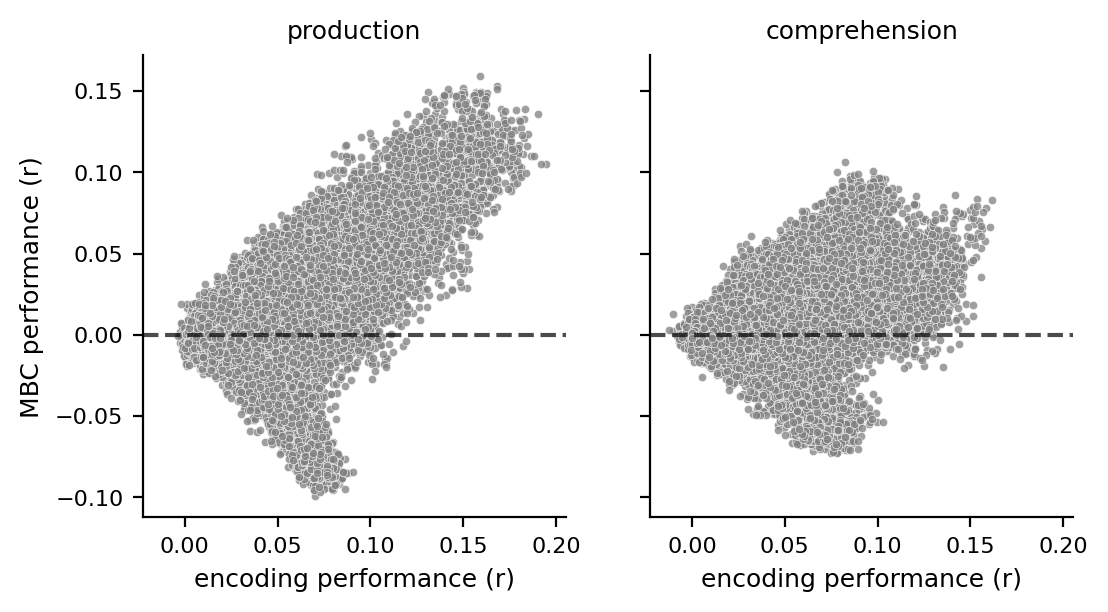

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200, sharex=True, sharey=True)

axes[0].scatter(prod_within[FG_MASK], sub_mbc_prod.mean(0)[FG_MASK], marker='.', alpha=0.75, c='gray', edgecolors='white', linewidths=0.25)
axes[1].scatter(comp_within[FG_MASK], sub_mbc_comp.mean(0)[FG_MASK], marker='.', alpha=0.75, c='gray', edgecolors='white', linewidths=0.25)

for ax in axes:
    ax.axhline(0, c="k", zorder=1, alpha=0.7, ls='dashed')
    ax.set_xlabel("encoding performance (r)")

axes[0].set_ylabel("MBC performance (r)")

axes[0].set_title('production')
axes[1].set_title('comprehension')

fig.show()

# weight similarity

In [ ]:
# sim between prod and comp
weight_sim_within = []
weight_sim_between = []

respath = Path(
    root='results/' + encmodel + '_n2',
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

for i, sub in enumerate(tqdm(SUBS_STRANGERS)):
    respath.update(sub=f"{sub:03d}")
    with h5py.File(respath, "r") as f:
        weights_prod = f["cv_weights_prod"][...].mean(0)
        weights_comp = f["cv_weights_comp"][...].mean(0)

    raw_corrs = correlation_score(weights_prod, weights_comp)
    weight_sim_within.append(raw_corrs)

    subB = subject.get_partner(sub)
    respath.update(sub=f"{subB:03d}")
    with h5py.File(respath, "r") as f:
        weights_compB = f["cv_weights_comp"][...].mean(0)
    raw_corrs = correlation_score(weights_prod, weights_compB)
    weight_sim_between.append(raw_corrs)

weight_sim_within = np.stack(weight_sim_within)
weight_sim_between = np.stack(weight_sim_between)
weight_sim_within.shape

In [23]:
# write
with h5py.File(f"{cachedir}/wbc.hdf5", "w") as f:
    f.create_dataset(name="within", data=weight_sim_within)
    f.create_dataset(name="between", data=weight_sim_between)

In [37]:
# read
with h5py.File(f"{cachedir}/wbc.hdf5", "r") as f:
    weight_sim_within = f["within"][...]
    weight_sim_between = f["between"][...]
weight_sim_between.shape

(58, 81924)

In [44]:
enc_sigmask = np.load('results/cache/figure2-enc/joint/trialmot9/sigmask.npy')

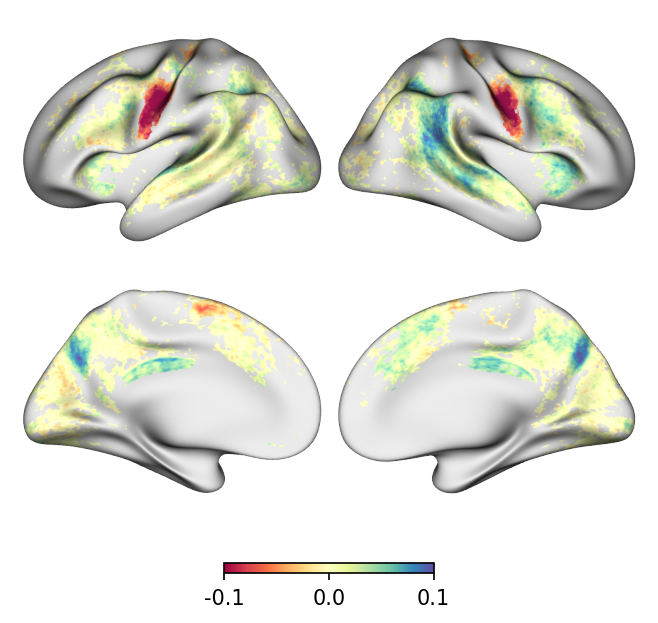

In [45]:
values = weight_sim_between.mean(0)
fig = plot.surface_plot(values, threshold=~enc_sigmask, cmap="Spectral")

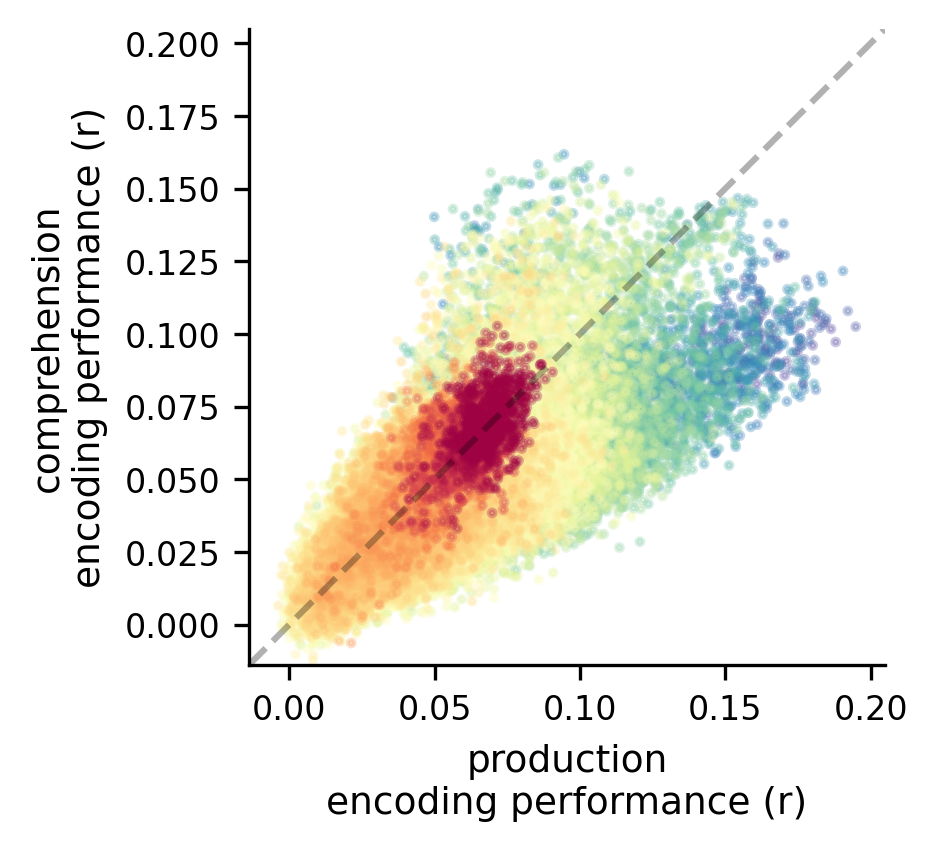

In [47]:
values1 = prod_scores
values2 = comp_scores

vox_colors  = weight_sim_between.mean(0)

order = vox_colors.argsort()[::-1]

fig = plt.figure(figsize=(2.75, 2.75), dpi=300)
ax = fig.add_subplot()

# ax.axvline(0, c="k", zorder=1, alpha=1)
# ax.axhline(0, c="k", zorder=1, alpha=1)
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, c="k", ls='dashed')

im = ax.scatter(
    values1[order], values2[order], c=vox_colors[order], s=10, alpha=0.3,
    # edgecolors='black', linewidths=0.25, marker='o',
    marker='.',
    cmap='Spectral', vmin=-.1, vmax=0.1)
ax.set_aspect("equal", "box")

lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], lim)
ax.set_ylim(ax.get_xlim()[0], lim)

ax.set_xlabel("production\nencoding performance (r)")
ax.set_ylabel("comprehension\nencoding performance (r)")

# cbar = fig.colorbar(im, shrink=0.86)
# cbar.set_label("density")

# cbar = fig.colorbar(im, ax=ax)

# sns.despine(fig, left=True, bottom=True)

fig.show()

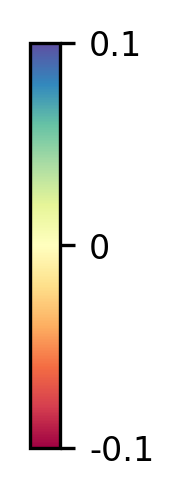

In [11]:
fig = plot.standalone_colorbar('Spectral', ticks=(0, 0.5, 1), tick_labels=(-.1, 0, .1), orientation='v')
fig.show()

# visualizing

In [65]:
subA = 104

In [114]:
# load subA preds
encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
with h5py.File(encpath, "r") as f:
    prod_predA = f["cv_preds"][:, -2]  # (5, 6, 240, 81924)
    comp_predA = f["cv_preds"][:, -1]
    prodmaskA = f["cv_prodmask"][...]

# load subB preds
subB = subject.get_partner(subA)
encpath = Path(root=encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
with h5py.File(encpath, "r") as f:
    nuis_predsB = f["cv_preds"][:, :-2].sum(1)#.reshape(1200, -1)

dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
# resB = dataB.reshape(5, 240, -1)
resB = dataB.reshape(5, 240, -1) - nuis_predsB
# resB = (dataB - zscore(nuis_predsB.reshape(1200, -1))).reshape(5, 240, -1)

compmaskA = ~prodmaskA

prod_predA.shape, comp_predA.shape, prodmaskA.shape, nuis_predsB.shape, resB.shape

((5, 240, 81924), (5, 240, 81924), (5, 240), (5, 240, 81924), (5, 240, 81924))

In [115]:
per_run = []
for i in range(5):
    per_run.append(correlation_score(prod_predA[i][prodmaskA[i]], resB[i][prodmaskA[i]]))
per_run = np.stack(per_run).mean(0)

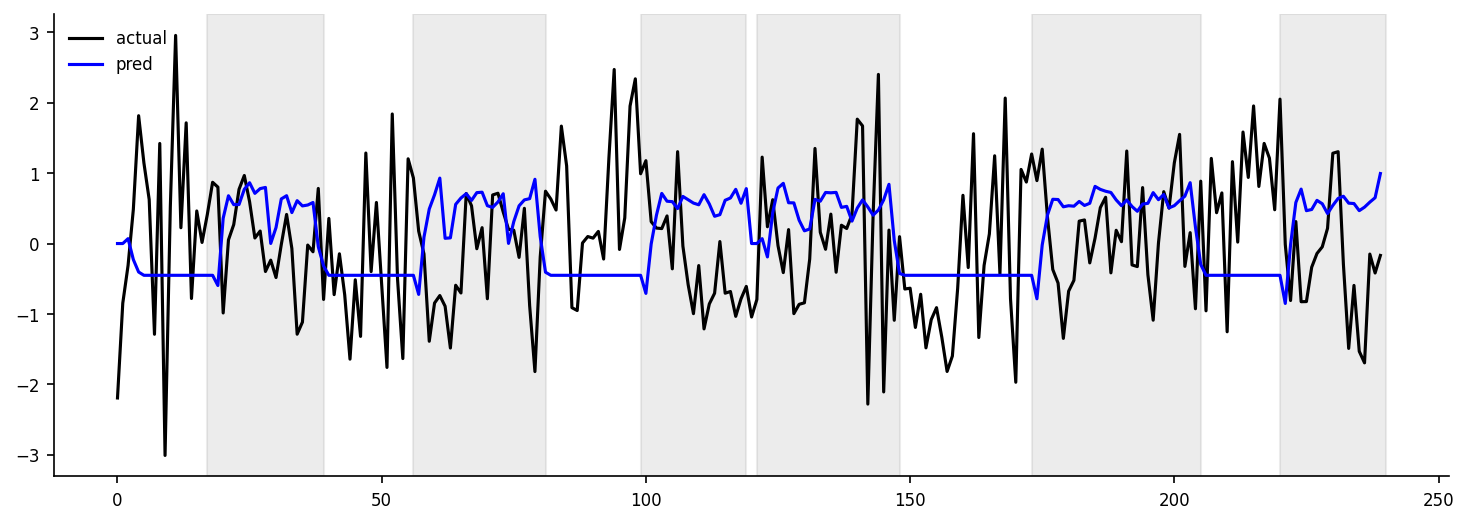

In [116]:
vox = 70117

fig, ax = plt.subplots(figsize=(12, 4))

switches = [0] + np.nonzero(np.diff(prodmaskA[0]))[0].tolist() + [240]
for i in range(1, len(switches)):
    if i % 2 == 0:
        ax.axvspan(switches[i - 1], switches[i], color="gray", alpha=0.15, zorder=1)
# ax.plot(prodmaskA[0], c='k')

plt.plot(resB[0, :, vox], label='actual', c='k')
plt.plot(prod_predA[0, :, vox], label='pred', c='b')

ax.legend()
fig.show()